# 数学(math)-统计学(statics)-采样(sampling)

### 0. 背景
+ 采样方法的基本目标时求解某个函数 f(x) 在某个特定的概率分布 p(x) 的期望值, 即 $\mathbb{E}[f(x)]=\int f(x) p(x) d x$ 
    + 这个形式与贝叶斯公式中的分母非常类似，因此也经常采用采样方法进行**近似求解归一化概率常数**
    + **但在x 的维度很高的时候，期望值是非常难求的**
+ 近似的解决办法是，从概率分布p(x) 中采样L个点，组成 $x_{s}=\left\{x^{(1)}, x^{(2)}, \cdots, x^{(L)}\right\}$， 粗略的估计期望数值 $\widehat{f}=\frac{1}{L} \sum_{i=1}^{L} f\left(x^{(i)}\right)$
    + 期望值是无偏的，粗略的估计方差 $\operatorname{var}[\widehat{f}]=\frac{1}{L} \mathbb{E}\left[(f-\mathbb{E}[f])^{2}\right]$

+ 实际应用中，经常会遇到p(x)无法采样的情况(在x是高维向量时不好采样，一维时可以），怎么从p(x)中采样L个变成了需要解决的问题
    + 针对这个问题常见的做法是：从常见的可采样的分布中采样，然后经过某种变化，得到从p(x)中采样的结果
    + 从常见的可采样的分布中采样 一般 是指从均匀分布采样 (计算机则只能实现对均匀分布进行抽样, 其他的分布，甚至如高斯分布都是无法实现的)
    + 下面会看到，**所有的随机模拟都从均匀分布开始的，然后经过所需分布的约束，获得所需样本的**

+ 常见的采样算法包括
+ 1. 均匀分布采样
+ 2. 离散分布采样
+ 3.1. Inverse CDF 
+ 3.2. 接受拒接采样
+ 3.3.  重要性采样
+ 4. MCMC
+ 4.3. M-H
+ 4.4. Gibbs

### 1. 均匀分布采样
+ 计算机中通过 线性同余发生器（linear congruential generator，LCG）[<sup>1</sup>](#refer-anchor) 很容易从一个 x∼Uniform[0,1) 的均匀分布中进行采样
+ 如果要从 y∼Uniform[a,b) 的均匀分布中采样，只需要 x 的基础上做个变换 y=(b−a)x+a 即可
+ 当然除了 LCG 外，还有其它均匀分布随机数生成方法，这里不一一列举，可以参考博客[<sup>2</sup>](#refer-anchor)
+ 单独把均匀分布采样摘出来是因为它很基础，很多其它采样方法都是在该基础上进行操作

### 2. 离散分布采样
+ 通过某种方法（比如 LCG）可以生成均匀分布的随机数，这个时候我们就完全可以对某个含有有限个离散取值的变量 r 进行采样，方法就是采用轮盘赌选择法。
+ 假设离散型变量 r 有 3 个取值，a1,a2,a3，概率分布如下图所示：

+ <img src="https://i.loli.net/2021/08/14/9mE1VHicK2nGAsY.png" width = "400" height = "300" alt="图片名称" align=center />
+ 所有取值概率之和为 1。此时我们可以从 Uniform[0,1) 生成一个随机数 b，若 0≤b<0.6，则选择出 a1；若 0.6≤b<0.7，则选择出 a2；若 0.7≤b<1，则选择出 a3。

### 3. 连续型分布采样(低维度)
+ 上面经讨论了从均匀分布 (U[a,b)) 中采样，对于其余分布，如高斯分布、gamma 分布、指数分布、t 分布、F 分布、Beta 分布、Dirichlet 分布等等，都可以基于 (U[0,1)) 的样本生成。

### 3.1 逆变换采样

+ 一些函数无法直接采样，可以采样逆变换法，利用PDF(概率密度函数) 与 CDF (累积分布函数) 的关系进行抽样

+ **例子1** 如下
    + 某函数的概率密度函数为 $f(x)=\frac{e^{x}}{1+e^{x}} \cdot \frac{1}{1+e^{x}} \quad x \in[-\infty,+\infty]$
    + 这个概率密度函数的累积分布函数为 $F(x)=P\{X \leq x\}=\frac{1}{1+e^{-x}} \quad x \in[-\infty,+\infty]$

In [46]:
import numpy  as np
import matplotlib.pyplot as plt
x = np.arange(-100,100,1)
y = np.exp(x)/(1 + np.exp(x)) * 1/(1 + np.exp(x))
z = 1/(1 + np.exp(-x))

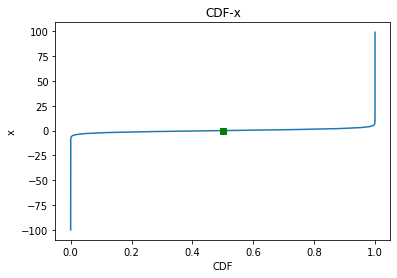

In [47]:
plt.plot(z,x)
plt.title('CDF-x')
plt.xlabel('CDF')
plt.ylabel('x')
plt.plot(0.5, 0, 'gs')
plt.show()

+ 由CDF的采样得到 对应的x
    + 如上图 为 CDF 和 x 之间的关系， 采样过程如下，在CDF 中 的取值范围[0,1] 中，通过均匀分布的方式采样，例如某采样得到的F(x) 为 0.5
    + F(x) 为0.5 时，对应的x为0
    + 下图为 x 和 CDF之间的关系

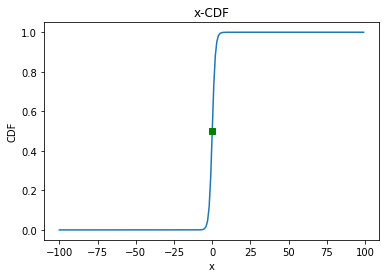

In [48]:
plt.plot(x,z)
plt.title('x-CDF')
plt.xlabel('x')
plt.ylabel('CDF')
plt.plot(0, 0.5, 'gs')
plt.show()

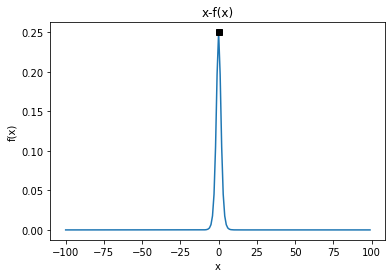

In [49]:
plt.plot(x,y)
plt.title('x-f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.plot(0, 0.25, 'ks')
plt.show()

+ **整体采样流程** 
    + 如上图，为x 和 f(x) 之间的关系，当x 为 0 时，对应的PDF 为0.25， 完成一次对 f(x)采样。（先用均匀分布采样得到一个CDF的值，通过CDF-x 曲线，得到对应的x的取值，之后通过 x-f(x) 曲线得到对应的PDF值，即f(x)值，完成一次采样）

+ 存在问题
    + 但对于不常见的分布，Inverse transform sampling应用起来就不太方便，因为累积分布函数的反函数不易求，甚至无法显式地求出。这时就需要用其他方法，比如下面提到的接受-拒绝采样, 重要性采样等等.

### 3.2 acceptance-rejection
+ 基本思想
    + 用一个“较大的概率分布” q(x)覆盖住“较小的概率分布”p(x)，这个"较大概率分布"比较好采样（标准分布）
    + 同时以一定的概率接受这个从样本，接受的样本可以看作是从”较小的概率分布“中采样得到的样本
+ 拒绝采样的一个关键参量是放大系数k
    + 原则上，k可以取得很大，从而满足总能全覆盖
    + 但拒绝概率与k成正比, 因此选取的k要尽可能的小,从而使得kq(x)恰好能覆盖p(x)

  + **例子2** [<sup>3</sup>](#refer-anchor)
    + 对 0.3 * np.exp(-(x - 0.3) ** 2) + 0.7 * np.exp(-(x - 2.) ** 2 / 0.3) 进行拒绝采样

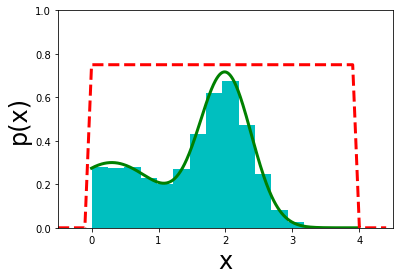

In [50]:
import numpy as np
import matplotlib.pyplot as plt
def qsample():
    """使用均匀分布作为q(x)，返回采样"""
    return np.random.rand() * 4.
def p(x):
    """目标分布"""
    return 0.3 * np.exp(-(x - 0.3) ** 2) + 0.7 * np.exp(-(x - 2.) ** 2 / 0.3)
def rejection(nsamples):
    M = 0.72  # 0.8 k值
    samples = np.zeros(nsamples, dtype=float)
    count = 0
    for i in range(nsamples):
        accept = False
        while not accept:
            x = qsample()
            u = np.random.rand() * M
            if u < p(x):
                accept = True
                samples[i] = x
            else:
                count += 1
    return samples
x = np.arange(0, 4, 0.01)
x2 = np.arange(-0.5, 4.5, 0.1)
realdata = 0.3 * np.exp(-(x - 0.3) ** 2) + 0.7 * np.exp(-(x - 2.) ** 2 / 0.3)
box = np.ones(len(x2)) * 0.75  # 0.8
box[:5] = 0
box[-5:] = 0
plt.plot(x, realdata, 'g', lw=3)
plt.plot(x2, box, 'r--', lw=3)

samples = rejection(10000)

plt.hist(samples, 15, density=1, fc='c')
plt.xlabel('x', fontsize=24)
plt.ylabel('p(x)', fontsize=24)
plt.axis([-0.5, 4.5, 0, 1])
plt.show()


+ 例子3
    + 采样 $y=x^2$, x 在[0,1] 之间 

In [51]:
import numpy as np
import random
import time

# y = x^2 的 定积分计算
def integral():   # 直接数值积分
    integral_value = 0
    for x in np.arange(0, 1, 1/10**7):
        integral_value = integral_value + x**2*(1/10**7)   # 对x^2在0和1之间积分
    return integral_value

def accept_reject():  # 使用均匀分布的接受拒绝采样
    n = 10**7
    x_min, x_max = 0.0, 1.0
    y_min, y_max = 0.0, 1.0
    count = 0
    for i in range(0, n):
        x = random.uniform(x_min, x_max)
        y = random.uniform(y_min, y_max)
        # x*x > y，表示该点位于曲线的下面。所求的积分值即为曲线下方的面积与正方形面积的比。
        if x * x > y:
            count += 1
    integral_value = count / n
    return integral_value


print('【计算时间】')
start_clock = time.perf_counter()  # 或者用time.clock()
a00 = 1/3  # 理论值
end_clock = time.perf_counter()
print('理论值（解析）：', end_clock-start_clock)

start_clock = time.perf_counter()
a0 = integral()  # 直接数值积分
end_clock = time.perf_counter()
print('直接数值积分：', end_clock-start_clock)

start_clock = time.perf_counter()
a1 = accept_reject()  # 用蒙特卡洛求积分投点法
end_clock = time.perf_counter()
print('用蒙特卡洛求积分_投点法：', end_clock-start_clock)

print('【计算结果】')
print('理论值（解析）：', a00)
print('直接数值积分：', a0)
print('用蒙特卡洛求积分_投点法：', a1)

print('【计算误差】')
print('理论值（解析）：', 0)
print('直接数值积分：', abs(a0-1/3))
print('用蒙特卡洛求积分_投点法：', abs(a1-1/3))

【计算时间】
理论值（解析）： 3.155699232593179e-05
直接数值积分： 5.3726358450367115
用蒙特卡洛求积分_投点法： 4.474216873000842
【计算结果】
理论值（解析）： 0.3333333333333333
直接数值积分： 0.33333328333333545
用蒙特卡洛求积分_投点法： 0.3335071
【计算误差】
理论值（解析）： 0
直接数值积分： 4.999999786425846e-08
用蒙特卡洛求积分_投点法： 0.00017376666666668594


+ 在高维的情况下，Rejection Sampling有两个问题：
    + 1.合适的q分布很难找
    + 2.很难确定一个合理的k值

### 3.3 重要性采样
+ 基本思想
    + 常用的是蒙特卡洛方法 $\int_{a}^{b} \frac{f(x)}{q(x)} q(x) d x$， q(x)为可以看作x在区间内的分布， $ \frac{f(x)}{q(x)} $ 看作一个函数，然后在q(x)下抽取n个样本，当n足够大时，可以用$\frac{f(x)}{q(x)}$ 多次采样的均值来表示f(x)的积分（进行如此变化的目的是希望 q(x) 是一个容易采样的函数)
+ 特性
    + 可降低估计方差(不理解，需要查找)

### 4. MCMC
+ **在高维空间中，拒绝采样和重要性采样很难寻找到合适参考分布，而且采样的效率是很低的，这个时候是可以考虑一下马尔科夫蒙特卡洛（Markov Chain Monte Carlo，MCMC）采样法**

### 4.1 马尔可夫链(Markov Chain)
+ 定义 
    + $P\left(X_{t+1}=x \mid X_{t}, X_{t-1}, \cdots\right)=P\left(X_{t+1}=x \mid X_{t}\right)$
    + 下一个状态只与当前状态有关，与之前的状态无关
+ 不同的链对应着不同的采样方法，常见的有两种有
    +  MH
    + Gibbs
+ MCMC是一个链式抽样的过程，每一个抽样的样本跟且只跟前面的一个样本有关系

### 4.2 马氏平稳条件
+ 如果非周期马尔科夫链的状态转移矩阵P和概率分布π(x)对于所有的i,j满足
    + $ \pi(i) P(i, j) = \pi(j) P(j, i) $
    + 则称概率分布π(x)是状态转移矩阵P的平稳分布
+ 由于马氏链能收敛到平稳分布， 于是一个很的漂亮想法是：
    + 如果我们能构造一个转移矩阵为P的马氏链，使得该马氏链的平稳分布恰好是p(x),那么我们从任何一个初始状态$x_0$, 出发沿着马氏链转移, 得到一个转移序列$x_0, x_1, x_2,...,x_n,⋯$, 如果马氏链在第n步已经收敛，那么$x_{n+1}$以后的样本必然都满足p(x)分布，就达到了我们的抽样样本满足概率为p(x)分布的条件
    + p(x) 是对应的平稳分布

+ **例子4**
    + 如下实验中 初始概率为 \[0.21, 0.68, 0.11\] 和 \[0.05, 0.94, 0.01\] 的情况，最终都收敛到了 \[0.4592545 0.3033419 0.2374036\] 的平稳条件(大概30轮)

In [52]:
import numpy as np
P = [[0.72, 0.17, 0.11], [0.33, 0.14, 0.53], [0.12,0.77,0.11]]
x_0 = [0.21, 0.68, 0.11]
for _ in range(30):
    print(x_0)
    x_0 = np.dot(np.asarray(P).T, np.asarray(x_0))

[0.21, 0.68, 0.11]
[0.3888 0.2156 0.3956]
[0.398556 0.400892 0.200552]
[0.44332092 0.27830444 0.27837464]
[0.44443648 0.32867565 0.22688786]
[0.45568378 0.29627245 0.24804377]
[0.45562748 0.30993809 0.23443443]
[0.45846349 0.30136251 0.240174  ]
[0.45836422 0.30506352 0.23657226]
[0.45908187 0.30279145 0.23812668]
[0.45903533 0.30379226 0.23717241]
[0.45921757 0.30318968 0.23759275]
[0.45920038 0.30345996 0.23733966]
[0.45924682 0.3033     0.23745318]
[0.45924109 0.30337291 0.237386  ]
[0.45925297 0.30333041 0.23741662]
[0.45925117 0.30335006 0.23739877]
[0.45925421 0.30333876 0.23740703]
[0.45925367 0.30334405 0.23740228]
[0.45925445 0.30334105 0.2374045 ]
[0.45925429 0.30334247 0.23740324]
[0.45925449 0.30334167 0.23740384]
[0.45925445 0.30334205 0.2374035 ]
[0.4592545  0.30334184 0.23740366]
[0.45925449 0.30334194 0.23740357]
[0.4592545  0.30334189 0.23740362]
[0.4592545  0.30334191 0.23740359]
[0.4592545 0.3033419 0.2374036]
[0.4592545  0.30334191 0.2374036 ]
[0.4592545 0.3033419 0

### 4.3 MH


+ 由于一般情况下，目标平稳分布$\pi(x)$和某一个马尔科夫链状态转移矩阵Q不满足细致平稳条件 $\pi(i) Q(i, j) \neq \pi(j) Q(j, i)$
+ 为了使平稳条件成立 
    + 构造公式
        + $\pi(i) Q(i, j) \alpha(i, j)=\pi(j) Q(j, i) \alpha(j, i)$
    + 为了使两边相等 
        + $\alpha(i, j)=\pi(j) Q(j, i)$ 
        + $\alpha(j, i)=\pi(i) Q(i, j)$
    + 这样得到的P为
        + $P(i, j)=Q(i, j) \alpha(i, j)$
+ 理解
    + 目标矩阵P可以通过任意一个马尔科夫链状态转移矩阵Q乘以$\alpha(i,j)$得到，$\alpha(i,j)$一般称为接受率，取值在\[0,1\]之间，即目标矩阵P可以通过任意一个马尔科夫链状态转移矩阵Q以一定的接受率获得
    + 与前面的拒绝采样比较
        + 拒绝采样是以一个常用的分布通过一定的拒绝率获得一个非常见的分布
        + MCMC则是以一个常见的马尔科夫链状态转移矩阵Q通过一定的拒绝率得到目标转移矩阵P，两者思路类似

+ 整体MH采样流程如下
+ 1. 初始化马尔可夫的初始状态 $X_0 = x_0$
+ 2. 循环采样过程如下
    + 2.1 第t 个时刻的马尔可夫状态为 $X_t = x_t$, 由转移矩阵$Q(x)$中采样得到 $y \sim q\left(x \mid x_{t}\right)$
    + 2.2 从均匀分布采样 $u \sim Uniform[0,1]$
    + 2.3 如果 $u<\alpha\left(x_{t}, y\right)=p(y) q\left(y, x_{t}\right)$, 则接受转移 $x_{t} \rightarrow y, X_{t+1}=y$
    + 2.4 否则不接受转移，即$X_{t+1} = x_t$

+ 流程问题
    + 马氏链Q在转移的过程中的接受率 α(i,j) 可能偏小，这样采样过程中马氏链容易原地踏步，拒绝大量的跳转
    + 使得马氏链遍历所有的状态空间要花费太长的时间，收敛到平稳分布p(x)的速度太慢

+ 改进方式
    + 假设 α(i,j)=0.1,α(j,i)=0.2, 此时满足细致平稳条件，于是 p(i)q(i,j)×0.1=p(j)q(j,i)×0.2
    + 上式两边扩大5倍，我们改写为 p(i)q(i,j)×0.5=p(j)q(j,i)×1
    + 如此操作提高了接受率，而细致平稳条件并没有打破，所以可以取接受率为 $\alpha(i, j)=\min \left\{\frac{p(j) q(j, i)}{p(i) q(i, j)}, 1\right\}$


+ 经过以上讨论，得到Metropolis-Hastings方法如下 [<sup>3</sup>](#refer-anchor)
+ 1. 初始化马尔可夫的初始状态 $X_0 = x_0$
+ 2. 循环采样过程如下
    + 2.1 第t 个时刻的马尔可夫状态为 $X_t = x_t$, 由转移矩阵$Q(x)$中采样得到 $y \sim q\left(x \mid x_{t}\right)$
    + 2.2 从均匀分布采样 $u \sim Uniform[0,1]$
    + 2.3 如果 $u<\alpha(i, j)=\min \left\{\frac{p(j) q(j, i)}{p(i) q(i, j)}, 1\right\}$, 则接受转移 $x_{t} \rightarrow y, X_{t+1}=y$
    + 2.4 否则不接受转移，即$X_{t+1} = x_t$

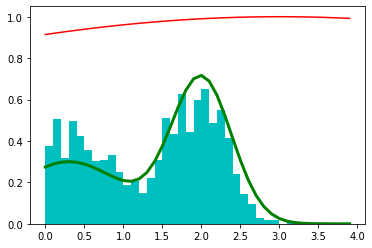

In [53]:
from __future__ import division
import numpy as np
import matplotlib.pylab as plt
mu = 3
sigma = 10
# 转移矩阵Q,因为是模拟数字，只有一维，所以Q是个数字(1*1)
def q(x):
    return np.exp(-(x-mu)**2/(sigma**2))
# 按照转移矩阵Q生成样本
def qsample():
    return np.random.normal(mu, sigma)
# 目标分布函数p(x)
def p(x):
    return 0.3*np.exp(-(x-0.3)**2) + 0.7* np.exp(-(x-2.)**2/0.3)
def mcmcsample(n = 20000):
    sample = np.zeros(n)
    sample[0] = 0.5 # 初始化
    for i in range(n-1):
        qs = qsample()  # 从转移矩阵Q(x)得到样本xt
        u = np.random.rand()  # 均匀分布
        alpha_i_j = (p(qs) * q(sample[i])) / (p(sample[i]) * qs)   # alpha(i, j)表达式
        if u < min(alpha_i_j, 1):
            sample[i + 1] = qs  # 接受
        else:
            sample[i + 1] = sample[i]  # 拒绝
    return sample
x = np.arange(0, 4, 0.1)
realdata = p(x)
sampledata = mcmcsample()
plt.plot(x, realdata, 'g', lw = 3)  # 理想数据
plt.plot(x,q(x),'r')  # Q(x)转移矩阵的数据
# plt.hist(sampledata,bins=x,normed=1,fc='c')  # 采样生成的数据
#  density=1
plt.hist(sampledata,bins=x,density=1,fc='c')
plt.show()

### 4.4 Gibbs Sampling
+ 基本思想
    + 吉布斯采样法是Metropolis-Hastings的一个特例，其核心是每次只对样本的一个维度进行采样和更新
    + 在高维的情况下，由于接受率α 的存在，Metropolis-Hastings算法效率不够高， 如果能找到一个转移矩阵Q使得$\alpha = 1$，那么抽样的效率会大大提高
+ 与以往方法的对比(**需要补充**)
    + 在拒绝采样中，如果在某一步得到的样本被拒绝，则该步不会产生新样本，需要重新进行采样
    + 在MH中，每一步都是会产生一个样本的，只是有的时候是保留旧样本罢

+ 例子5
    + 在二维情况下，有一个概率分布为p(x,y), x坐标相同的两个点A(x_1, y_1), B(x_1, y_2)
    + 根据贝叶斯公式，有
        + $p\left(x_{1}, y_{1}\right) p\left(y_{2} \mid x_{1}\right)=p\left(x_{1}\right) p\left(y_{1} \mid x_{1}\right) p\left(y_{2} \mid x_{1}\right)$
        + $p\left(x_{1}, y_{2}\right) p\left(y_{1} \mid x_{1}\right)=p\left(x_{1}\right) p\left(y_{2} \mid x_{1}\right) p\left(y_{1} \mid x_{1}\right)$
    + 联立得到
        + $p\left(x_{1}, y_{1}\right) p\left(y_{2} \mid x_{1}\right)=p\left(x_{1}, y_{2}\right) p\left(y_{1} \mid x_{1}\right)$
    + 即
        + $p(A) p\left(y_{2} \mid x_{1}\right)=p(B) p\left(y_{1} \mid x_{1}\right)$


+ 二维Gibbs 采样流程如下
    + 1. 随机初始化 X_0 = x_0, Y_0 = Y_0
    + 2. 循环采样
    + 2.1  $y_{t+1} \sim p\left(y \mid x_{t}\right)$
    + 2.2 $x_{t+1} \sim p\left(x \mid y_{t+1}\right)$

+ 通过以上推导可以发现，在x=x_1 这条直线上，如果用P(y|x_1) 作为任意两个点之间的转移概率，那么任意两个点之间的转移满足细致平稳条件
+ **当采样几个变量，但是不知道其联合分布，但是知道几个变量相互之间所有的条件分布时，我们可以用其来获取一些近似观察样本**

/Users/sunhongchao/miniconda3/envs/env_bot/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/sunhongchao/miniconda3/envs/env_bot/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


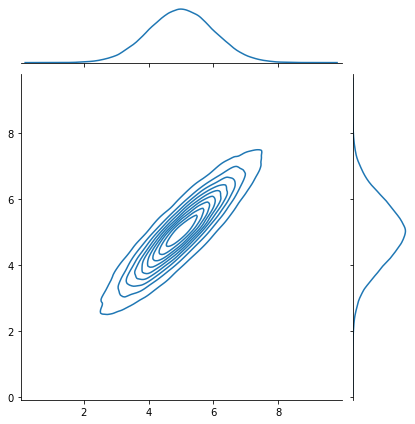

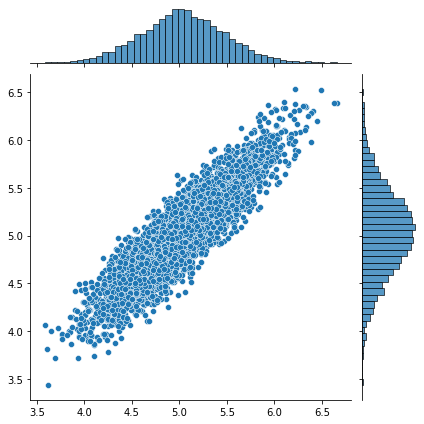

In [55]:
import numpy as np
import seaborn as sns

def p_x_given_y(y, mus, sigmas):
    # 二元高斯分布计算边缘分布
    # 
    mu = mus[0] + sigmas[1, 0] / sigmas[0, 0] * (y - mus[1])
    sigma = sigmas[0, 0] - sigmas[1, 0] / sigmas[1, 1] * sigmas[1, 0]
    return np.random.normal(mu, sigma) # Gaussian 分布

def p_y_given_x(x, mus, sigmas):
    mu = mus[1] + sigmas[0, 1] / sigmas[1, 1] * (x - mus[0])
    sigma = sigmas[1, 1] - sigmas[0, 1] / sigmas[0, 0] * sigmas[0, 1]
    return np.random.normal(mu, sigma)

def gibbs_sampling(mus, sigmas, iter=int(5e3)):
    samples = np.zeros((iter, 2))
    y = np.random.rand() * 10

    for i in range(iter):
        x = p_x_given_y(y, mus, sigmas)
        y = p_y_given_x(x, mus, sigmas)
        samples[i, :] = [x, y]

    return samples

if __name__ == '__main__':
    mus = np.array([5, 5])
    sigmas = np.array([[1, .9], [.9, 1]])

    # plot the ground truth
    # 多元正太分布
    x,y = np.random.multivariate_normal(mus, sigmas, int(1e5)).T
    sns.jointplot(x,y,kind="kde")

    # plot the Gibbs sampling results
    samples = gibbs_sampling(mus, sigmas)
    sns.jointplot(samples[:, 0], samples[:, 1])

### 5 其他采样方法
+ 不平衡样本采样
    + https://zhuanlan.zhihu.com/p/76024846
+ 切片采样
    + https://zhuanlan.zhihu.com/p/62730810

# View
+ MH 相关补充 https://zhuanlan.zhihu.com/p/62730810 统计学习方法第二版 Comparing Gibbs
+ 采样方法 https://zhuanlan.zhihu.com/p/62730810
+ 质量较好 机器学习中的9中采样方法 https://www.cnblogs.com/vpegasus/p/sampling.html
+ 有代码 采样方法详细解读与代码实现 https://blog.csdn.net/bitcarmanlee/article/details/82795137
+ [随机采样方法整理与讲解](https://zhuanlan.zhihu.com/p/109978580)
+ Gibbs sampling
    + https://wiseodd.github.io/techblog/2015/10/09/gibbs-sampling/
    + https://github.com/zhuanxuhit/math-foundation/blob/master/mcmc/gibbs-sampling.ipynb
+ [机器学习主题模型之LDA参数求解——Gibbs采样](https://blog.csdn.net/liuy9803/article/details/81212239?utm_medium=distribute.pc_relevant.none-task-blog-baidujs_baidulandingword-1&spm=1001.2101.3001.4242)
    + 有详细的推理过程，还有LDA中gibbs的使用 
+ [Introduction to MCMC for Machine Learning](https://www.cs.ubc.ca/~arnaud/andrieu_defreitas_doucet_jordan_intromontecarlomachinelearning.pdf)
+ scipy 
    + pdf：连续随机分布的概率密度函数
    + pmf：离散随机分布的概率密度函数
    + cdf：累计分布函数
    + ppf: 百分位函数（累计分布函数的逆函数）
    + lsf: 生存函数的逆函数（1 - cdf 的逆函数）

<div id="refer-anchor"></div>

# Reference  
[1] [wiki 线性同余发生器](https://zh.wikipedia.org/wiki/%E7%B7%9A%E6%80%A7%E5%90%8C%E9%A4%98%E6%96%B9%E6%B3%95) 
[2] [随机数生成（一）：均匀分布](https://blog.csdn.net/JackyTintin/article/details/7798157) 
[3] [史上最全采样方法详细解读与代码实现](https://blog.csdn.net/bitcarmanlee/article/details/82795137) 